In [35]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [36]:
import numpy as np
import pandas as pd

In [37]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [39]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [41]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

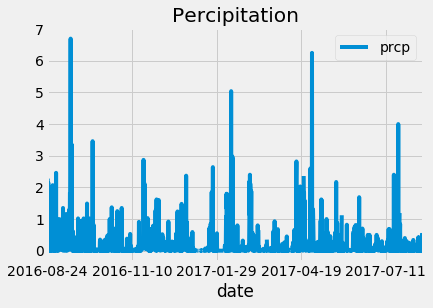

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = (session.query(Measurement.date)
                .order_by(Measurement.date.desc()).first())
latest_date = list(np.ravel(latest_date))[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_day = int(dt.datetime.strftime(latest_date, '%d'))

# Calculate the date 1 year ago from the last data point in the database
year_before = dt.date(latest_year, latest_month, latest_day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_before).order_by(Measurement.date).all())

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title = "Percipitation")

![precipitation](Images/precipitation.png)

In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data\
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [46]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station).count() 
total_stations

9

In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
most_active = active_station[0][0]
most_active

'USC00519281'

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
lowest_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active).order_by(Measurement.tobs.asc()).first()
lowest_temp = lowest_temp[0]
lowest_temp
print(f'lowest_temp = {lowest_temp}')
# highest temperature recorded, and average temperature of the most active station?
highest_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active).order_by(Measurement.tobs.desc()).first()
highest_temp = highest_temp[0]
highest_temp
print(f'highest_temp = {highest_temp}')

lowest_temp = 54.0
highest_temp = 85.0


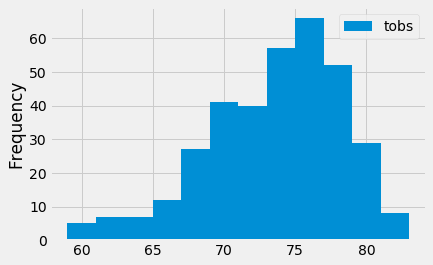

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > year_before).filter(Measurement.station == most_active).order_by(Measurement.date).all()
temp_df = pd.DataFrame(temp_data)
temp_df = temp_df.set_index('date')
temp_df = temp_df.sort_index(ascending=True)
temp_df.plot(kind='hist', bins=12)

![precipitation](Images/station-histogram.png)

In [51]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = '2017-01-01 to \n 2017 -01-016'
trip_start = '2017-01-01'
trip_end = '2017-01-16'
trip_temps = calc_temps('2016-01-01', '2016-01-16')
trip_temps

[(62.0, 69.76595744680851, 78.0)]

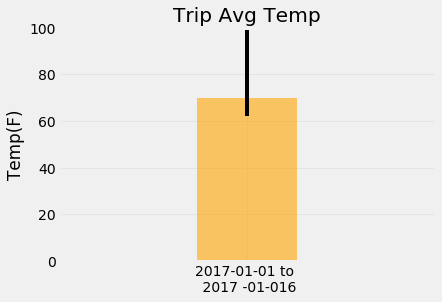

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_trip_temp = trip_temps[0][0]
avg_trip_temp = trip_temps[0][1]
max_trip_temp = trip_temps[0][2]

min_error = avg_trip_temp - min_trip_temp
max_error = max_trip_temp = avg_trip_temp

error_bars = np.array([[min_error],  [max_error]])

plt.bar(trip, avg_trip_temp, yerr=error_bars, color = 'orange', alpha = .6)
plt.ylim(0,100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.grid(alpha = .3)

In [55]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [56]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation])

station_rain = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

station_rain_df = pd.DataFrame(np.array(station_rain))
station_rain_df = station_rain_df.rename(columns = {0: "Station", 1: "Location", 2: "Total Percipititaion", 3: "Latitude", 4: "Longitude", 5: "Elevation"})

station_rain_df

,Station,Location,Total Percipititaion,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.64,21.3331,-157.803,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.63,21.5213,-157.837,7
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.61,21.3356,-157.711,19.5
3,USC00513117,"KANEOHE 838.1, HI US",0.35,21.4234,-157.802,14.6
4,USC00519281,"WAIHEE 837.5, HI US",0.21,21.4517,-157.849,32.9
5,USC00519397,"WAIKIKI 717.2, HI US",0,21.2716,-157.817,3
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9


In [57]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
start_date = "2017-01-01"
end_date = "2017-01-16"
start_num = int(start_date[-2:])
end_num = int(end_date[-2:])
trip_length = end_num -start_num + 1

trip_start = dt.datetime.strptime(trip_start, '%Y-%m-%d')
date_list = [dt.datetime.strftime(trip_start + dt.timedelta(days = x), '%m-%d')
    for x in range(0, trip_length)]

trip_norm = [daily_normals(date) for date in date_list]
trip_norm

[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)],
 [(57.0, 67.16071428571429, 75.0)],
 [(58.0, 67.9298245614035, 78.0)],
 [(62.0, 69.74137931034483, 77.0)],
 [(57.0, 67.3103448275862, 78.0)],
 [(57.0, 67.4074074074074, 81.0)],
 [(57.0, 67.25454545454545, 77.0)],
 [(58.0, 69.52631578947368, 77.0)],
 [(56.0, 69.31372549019608, 78.0)],
 [(54.0, 68.62962962962963, 80.0)]]

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_norm = [np.array(normal[0]) for normal in trip_norm]
trip_norm_df = pd.DataFrame(trip_norm)
trip_norm_df["Date"] = date_list
trip_norm_df = trip_norm_df.set_index("Date")
trip_norm_df = trip_norm_df.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})
trip_norm_df

,Low Temp,Avg Temp,High Temp
Date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0


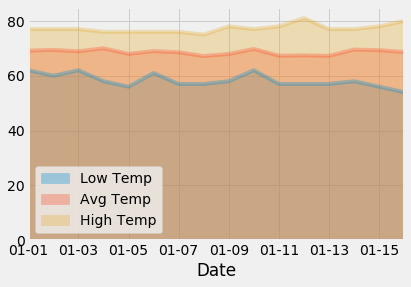

In [59]:
# Plot the daily normals as an area plot with `stacked=False`
trip_norm_df.plot.area(stacked=False, alpha = .333)